In [25]:
!pip install openai
!pip install shap
!pip install tqdm
!pip install openpyxl
!pip install langchain

     |████████████████████████████████| 249 kB 4.6 MB/s eta 0:00:01


In [2]:
#Note: The openai-python library support for Azure OpenAI is in preview.
import os
import openai
import matplotlib.pyplot as plt
#!pip install mltable
#!pip install azure.ai.ml
import shap
import sklearn
import pandas as pd
# import shap
import sklearn
import pandas as pd
import mlflow
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from langchain.chat_models import AzureChatOpenAI

In [3]:
data_df = pd.read_csv('data/1429_1.csv')
data_df.head()

Columns (1,10) have mixed types.Specify dtype option on import or set low_memory=False.


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


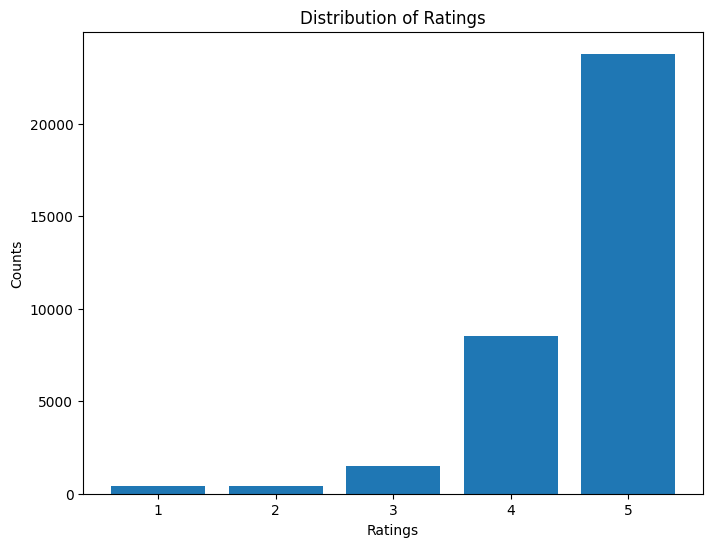

In [4]:
ratings_counts = data_df["reviews.rating"].value_counts()

# Calculate percentages
total_ratings = ratings_counts.sum()
ratings_percentages = (ratings_counts / total_ratings) * 100

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(ratings_counts.index, ratings_counts)
plt.xlabel("Ratings")
plt.ylabel("Counts")
plt.title("Distribution of Ratings")
plt.show()

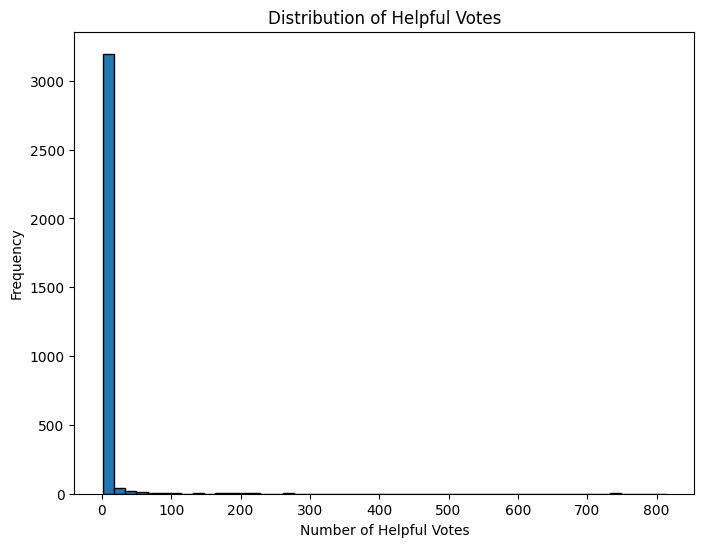

In [5]:
num_helpful_data = data_df['reviews.numHelpful']

# removing all 0
num_helpful_data = num_helpful_data[num_helpful_data != 0]
# Create the distribution plot
plt.figure(figsize=(8, 6))
plt.hist(num_helpful_data, bins=50, edgecolor='black')
plt.xlabel('Number of Helpful Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Helpful Votes')
plt.show()

In [6]:
openai.api_type = "azure"
openai.api_base = "https://open-ai-demo-jp.openai.azure.com/"
openai.api_version = ""
openai.api_key = ""# insert your key here 

**Sentiment Analysis** : using AOAI for Sentimental analysis as positive, negative and Neutral 

In [ ]:
def analyze_my_review(review):
    retries = 3
    sentiment = None

    while retries > 0:
        messages = [
            {"role": "system", "content": "You are an AI language model trained to analyze and detect the sentiment of product reviews."},
            {"role": "user", "content": f"Analyze the following product review and determine if the sentiment is: positive, negative or neutral. Return only a single word, either POSITIVE, NEGATIVE or NEUTRAL: {review}"}
        ]

        completion = openai.ChatCompletion.create(
            engine="gm-aou-demov1",
            messages=messages,
            # We only want a single word sentiment determination so we limit the results to 3 openAI tokens, which is about 1 word. 
            # If you set a higher max_tokens amount, openAI will generate a bunch of additional text for each response, which is not what we want it to do
            max_tokens=3,
            n=1,
            stop=None,
            temperature=0
        )

        response_text = completion.choices[0].message.content
        # print the sentiment for each customer review, not necessary but it's nice to see the API doing something :)
        print(response_text)

        # Sometimes, the API will be overwhelmed or just buggy so we need to check if the response from the API was an error message or one of our allowed sentiment classifications.
        # If the API returns something other than POSITIVE, NEGATIVE or NEUTRAL, we will retry that particular review that had a problem up to 3 times. This is usually enough.
        if response_text in ["POSITIVE", "NEGATIVE", "NEUTRAL"]:
            sentiment = response_text
            break
        else:
            retries -= 1
            time.sleep(0.5)
    else:
        sentiment = "neutral"

    retries = 3
   
    # OpenAI will limit the number of times you can access their API if you have a free account. 
    # If you are using the Azure openAI free tier, you need to add a delay of a few seconds (i.e. 4 seconds) between API requests to avoid hitting the openai free tier API call rate limit.
    # This code will still work with an openAI free tier account but you should limit the number of reviews you want to analyze (<100 at a time) to avoid running into random API problems.

    time.sleep(0.5)

    return sentiment

In [15]:
# Testing with a Proof of Concept -- First  5 rows only  

df  = data_df.head(5) 

# Analyze each review using ChatGPT and save the results in a list called sentiments so we can access the results later
sentiments = []

# Here we loop through all of the reviews in our dataset and send them to the openAI API using our custom function from above
for review in tqdm(df["reviews.text"], desc="Processing reviews"):
    sentiment = analyze_my_review(review)
    sentiments.append(sentiment)

# Now let's save the openAI API results as an additional column in our original dataset
df["sentiment"] = sentiments
df.head()

Processing reviews: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


POSITIVE
POSITIVE
POSITIVE
POSITIVE
POSITIVE


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sentiment
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter,POSITIVE
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman,POSITIVE
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ,POSITIVE
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks,POSITIVE
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42,POSITIVE


****

In [26]:
import pandas as pd 
# Write the DataFrame to an Excel file
df.to_excel('data/export_test.xlsx')

** Summarize A Review** : You can also Summarize a review based on specific product of focus.


**For example ** : let us say you only want to focus on one product and summarize all views on what people are saying - you can do that as well.


We will use example of **All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta** as the product

In [17]:
# Use this code block if you ONLY want to summarize long reviews into short, 75 word versions. This code will NOT try to classify the sentiment of each review
def summarize_review(review):
    retries = 3
    summary = None

    while retries > 0:
        # This time, we are only summarizing the reviews, not determining the sentiment so we change the prompt (ie command) for chatGPT to the following
        messages = [
            {"role": "system", "content": "You are an AI language model trained to analyze and summarize product reviews."},
            {"role": "user", "content": f"Summarize the following product review, highlighting pros and cons: {review}"}
        ]

        
        completion2 = openai.ChatCompletion.create(
           engine="gm-aou-demov1",
            messages=messages,
            # We want to limit the summarizes to about 75 words (which is around 100 tokens). If you want longer review summaries, increase the max_tokens amount
            max_tokens=100,
            n=1,
            stop=None,
            temperature=0.8
        )

        response_text = completion2.choices[0].message.content
        # This is optional but it's nice to see how the reviews are being summarized to make sure something isn't wrong with the input file or API results
        print(response_text)
        
        # This is our quality control check. If the API has an error and doesn't generate a summary, we will retry the review 3 times. 
        if response_text:
            summary = response_text
            break
        else:
            retries -= 1
            time.sleep(0.5)
    else:
        summary = "Summary not available."

    # OpenAI will limit the number of times you can access their API if you have a free account. 
    # If you are using the openAI free tier, you need to add a delay of a few seconds (i.e. 4 seconds) between API requests to avoid hitting the openai free tier API call rate limit.
    # This code will still work with an openAI free tier account but you should limit the number of reviews you want to analyze (<100 at a time) to avoid running into random API problems.

    time.sleep(0.5)

    return summary

In [18]:
# Testing with a Proof of Concept --All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
df_1 = data_df[data_df["name"]=='All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta']

In [19]:
# Testing with a Proof of Concept --All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
# After chatGPT summarizes the review, we save the summary to a list called summaries

summaries = []

for review in tqdm(df["reviews.text"], desc="Processing reviews"):
    summary = summarize_review(review)
    summaries.append(summary)

# Now we add the review summaries to the original input dataframe
df["summary"] = summaries




Processing reviews: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


This review highlights the positive aspects of the product, including its ability to keep children entertained and the ease of monitoring and controlling content. However, it does not mention any negative aspects or cons of the product.
This product review is very brief and to the point. The reviewer states that the product is great for both beginners and experienced individuals and was purchased as a gift for someone who loves it. There is no clear mention of any specific pros or cons.
The reviewer is satisfied with the inexpensive tablet as it serves the purpose of learning and is a step up from their previous device. They also mention that they were able to learn how to use Skype on the tablet. However, there is no mention of any cons or drawbacks associated with the product.
The reviewer is very satisfied with the Fire HD 8 and thinks it is a great value. One of the pros is its compatibility with Amazon Prime content and the ability to download movies for later viewing. The screen 

** Summarize over the pros and cons **

In [28]:
def generate_proscons_list(text):
    word_blocks = text.split(' ')
    block_size = 2500
    blocks = [' '.join(word_blocks[i:i + block_size]) for i in range(0, len(word_blocks), block_size)]

    proscons = []

    for block in tqdm(blocks, desc="Processing blocks", unit="block"):
        messages = [
            {"role": "system", "content": "You are an AI language model trained to create a list of the most common pros and cons for products based on product review summaries."},
            {"role": "user", "content": f"Based on the following product review summaries, create a list of the most common pros and cons for the product: {block}"}
        ]

        completion = openai.ChatCompletion.create(
            engine="gm-aou-demov1",
            messages=messages,
            # You can change the max_tokens amount to increase or decrease the length of the results pros and cons list. If you increase it too much, you will exceed chatGPT's limits though.
            max_tokens=300,
            n=1,
            stop=None,
            # You can adjust how "creative" (i.e. true to the original reviewer's intent) chatGPT will be with it's summary be adjusting this temperature value. 0.7 is usually a safe amount
            temperature=0.7
        )

        procon = completion.choices[0].message.content
        proscons.append(procon)

    # Combine the pros and cons that chatGPT found into a list 
    combined_proscons = "\n\n".join(proscons)
    return combined_proscons


In [30]:
# Combine all of the pros and cons from the various review chunks into one list 
all_reviews = "\n".join(df["reviews.text"].tolist())

# This is the call to the function we created above that will trigger the API call
summary_proscons = generate_proscons_list(all_reviews)

# Print the list of pros and cons (optional step)
print(summary_proscons)



# Save the resulting list of pros and cons to a new Excel file for further offline processing
df_proscons = pd.DataFrame()
list_proscons = []
list_proscons.append(summary_proscons)
df_proscons["pros_cons"] = list_proscons

Processing blocks: 100%|██████████| 1/1 [00:02<00:00,  2.34s/block]


Pros:
- Easy to use and monitor content
- Great for beginners and experienced users
- Inexpensive and good value for money
- Good screen quality and brightness
- Sleek and futuristic design
- Simple to set up with age-appropriate content filters
- Plenty of storage with additional SD card

Cons:
- None mentioned in the review summaries


In [31]:
df_proscons.head()

,pros_cons
0,Pros:\n- Easy to use and monitor content\n- Gr...


In [37]:
def generate_improvement_suggestions(text):
    # This code splits the total reviews text into blocks of 2,500 tokens (about 1,800 words) to comply with openAI's API limits
    word_blocks = text.split(' ')
    block_size = 2500
    blocks = [' '.join(word_blocks[i:i + block_size]) for i in range(0, len(word_blocks), block_size)]

    suggestions = []

    for block in tqdm(blocks, desc="Processing blocks", unit="block"):
        # Here we specify the role for chatGPT to assume and give it the command to suggest 10 product improvements based on the block of customer review data it just read
        messages = [
            {"role": "system", "content": "You are an AI language model trained to analyze product reviews and generate suggestions for product improvements."},
            {"role": "user", "content": f"Based on the following product reviews, suggest 10 product improvements: {block}"}
        ]

        completion = openai.ChatCompletion.create(
            engine="gm-aou-demov1",
            messages=messages,
            max_tokens=300,
            n=1,
            stop=None,
            temperature=0.7
        )

        suggestion = completion.choices[0].message.content
        suggestions.append(suggestion)

    # Combine all suggestions together
    combined_suggestions = "\n\n".join(suggestions)
    return combined_suggestions

In [38]:
# Combine all of the suggestions into a single text
review_improvements = "\n".join(df["reviews.text"].tolist())

# Call the custom function we created above to generate improvement suggestions from the review data
improvement_suggestions = generate_improvement_suggestions(review_improvements)

# Print the improvement suggestions (optional step, you can remove it)
print(improvement_suggestions)

# Save the resulting list of product improvement suggestions to a new Excel file
df_improvements = pd.DataFrame()
list_improvements = []
list_improvements.append(improvement_suggestions)
df_improvements["improvement_suggestions"] = list_improvements

Processing blocks: 100%|██████████| 1/1 [00:03<00:00,  3.92s/block]


Based on the reviews, here are 10 product improvements:

1. Add more parental control features to ensure children's safety while using the tablet.
2. Improve the user interface to make it more intuitive and user-friendly.
3. Increase the battery life of the tablet to provide longer usage time.
4. Enhance the storage capacity of the tablet to accommodate more apps and files.
5. Introduce more colors and designs to provide users with more options.
6. Improve the camera quality to provide users with better photos and videos.
7. Increase the processing speed to make the tablet more responsive.
8. Add more pre-installed apps to offer a wider variety of features to users.
9. Provide regular software updates to ensure the tablet's performance and security.
10. Make the tablet more durable to withstand accidental drops and bumps.


In [39]:
df_improvements.head()

,improvement_suggestions
0,"Based on the reviews, here are 10 product impr..."
